In [42]:
%matplotlib inline

from __future__ import print_function

from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Reshape, Dropout
from keras.layers import add, dot, multiply, concatenate
from keras.layers import LSTM, Conv1D, TimeDistributed, Lambda
from keras.initializers import Constant
from keras import backend as K
from keras import utils
from keras.callbacks import ModelCheckpoint
import numpy as np

from dataproc_utils import load_wordvecs, load_proc_data, make_word_freq_V, word2idx, vocab_vectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf

from matplotlib import pyplot as plt

In [2]:
batch_size = 64
epochs = 25
random_state = 42
n_pars = 9 # max number of paragraphs from each document
par_size = 15  # max paragraph length (num of words in each paragraph)
claim_size = 15  # max num of words in each claim
embedding_dim = 25  # should be 100
output_size = 4  # size of the output vector, corresponds to the number of classes

# Embeddings from Glove

Only the words we use

In [3]:
# open saved wordvecs from file
w2v = load_wordvecs('twitter_glo_vecs\\wordvecs25d.txt')
print(len(w2v), 'pretrained embeddings')

17355 pretrained embeddings


# Preprocessed data

- document per line
- claim per line

In [4]:
# load data and labels
data = load_proc_data('processed_data\\train_bodies.txt', 'processed_data\\train_claims.txt', split_pars=True)
labels = [label for body, claim, label in data]
y = np.array(labels)

In [5]:
# initialize tfidf tokenizer
# fit on concatenated list of bodies and claims
# and transform bodies/pars and claims at the same time
# measure cosine similarity btw tfidf representations of bodies & claims to compute p_tfidf (claim-evidence sim vector)
# tfidf_body shape (len(claims), n_pars, vocab size)
# tfidf_claim shape (len(claims), vocab size)
# p_tfidf output shape: (len(claims), n_pars)

# load pre-computed p_tfidf similarity matrix for train data
p_tfidf = np.loadtxt('processed_data\\p_tfidf_train.txt', dtype=np.float32)
print('Shape of similarity matrix train p_tfidf:', p_tfidf.shape)

Shape of similarity matrix train p_tfidf: (49972, 9)


# TFIDF

Tfidf computed for every claim. Each claim is matched to one document (9 paragraphs). NOTE: Claims might repeat, but with new document as reference.

In [6]:
# train/validation split
train_data, val_data, train_p_tfidf, val_p_tfidf, train_labels, val_labels = train_test_split(data, p_tfidf, y,
                                                                                              test_size=.2,
                                                                                              random_state=random_state)
# print('First input tuple (body, claim, stance):\n', train_data[0])
# print('First input p_tfidf:\n', train_p_tfidf[0])

In [7]:
# create a vocabulary dict from train data (we exclude rare words, which appear only once)
word2freq = make_word_freq_V(train_data, fmin=2)
word2index = word2idx(word2freq, pretrained=w2v)
vocab_size = len(word2index)
print('Vocab size:', vocab_size, 'unique words in the train set which have glove embeddings')

Vocab size: 16908 unique words in the train set which have glove embeddings


In [85]:
index2word = {v:k for k,v in word2index.items()}

In [127]:
index2word[0] = 'unknown'

# Vectorize

In [8]:
# vectorize input words (turn each word into its index from the word2index dict)
# for new words in test set that don't appear in train set, use index of <unknown>
train_body, train_claim = vocab_vectorizer(train_data, word2index, max_par_len=par_size, max_claim_len=claim_size)
val_body, val_claim = vocab_vectorizer(val_data, word2index, max_par_len=par_size, max_claim_len=claim_size)

# Prepare embedding matrix

In [9]:
# prepare embedding matrix
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for w, i in word2index.items():
    embedding_matrix[i] = w2v[w]

# Embeddings

In [10]:
# load pre-trained word vectors into embedding layers
# we set trainable to false to keep the embeddings fixed
embedding_body = Embedding(vocab_size + 1,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=(n_pars, par_size,),
                            trainable=False)

embedding_claim = Embedding(vocab_size + 1,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=claim_size,
                            trainable=False)

In [11]:
# initialize input placeholders and embed pre-trained word vectors
input_body = Input(shape=(n_pars, par_size,), dtype='int32', name='docs')
input_claim = Input(shape=(claim_size,), dtype='int32', name='claims')
input_p_tfidf = Input(shape=(n_pars,), dtype='float32', name='tfidf')

print('input body', input_body.shape)     # (?, 9, 15)
print('input claim', input_claim.shape)    # (?, 15)
print('input p_tfidf', input_p_tfidf.shape)  # (?, 9)

input body (?, 9, 15)
input claim (?, 15)
input p_tfidf (?, 9)


In [12]:
embedded_body = embedding_body(input_body)
embedded_claim = embedding_claim(input_claim)

print('embedded body', embedded_body.shape)   # (?, 9, 15, 25)
print('embedded claim', embedded_claim.shape)  # (?, 15, 25)

embedded body (?, 9, 15, 25)
embedded claim (?, 15, 25)


# CNNs

## Paragraphs

In [13]:
# train two 1D convnets (should be time distributed with maxout layer)
cnn_body = TimeDistributed(Conv1D(100, 5, padding='valid', activation='relu'), name='CNN_docs')(embedded_body)
cnn_body = Lambda(lambda x: K.max(x, axis=-1, keepdims=False), name='CNN_maxout_docs')(cnn_body)  # this should be maxout
#cnn_body = Lambda(lambda x: tf.contrib.layers.maxout(x, num_units=1))(cnn_body) ## does not work for some reason!!?

## Claims

In [14]:
cnn_claim = Conv1D(100, 5, padding='valid', activation='relu', name='CNN_claims')(embedded_claim)
cnn_claim = Lambda(lambda x: K.max(x, axis=-1, keepdims=False), name='CNN_maxout_claims')(cnn_claim)  # this should be maxout
#cnn_claim = Lambda(lambda x: tf.contrib.layers.maxout(x, num_units=1))(cnn_claim) ## does not work

For Maxout, we take the maximum value of the 100 values in the vector extracted by the CNN

In [15]:
# maxout eliminates the last dimension from the cnn representations:
# converts cnn_body with shape (?, 9, 11, 100) to (?, 9, 11)
# and cnn_claim with shape (?, 11, 100) to (?, 11)
print('cnn_body shape', cnn_body.shape)  # (?, 9, 11)
print('cnn_claim shape', cnn_claim.shape)  # (?, 11)

cnn_body shape (?, 9, 11)
cnn_claim shape (?, 11)


# LSTMs

- TimeDistributed for documents
- simple for claims

In [16]:
# train two lstms
lstm_body = TimeDistributed(LSTM(100), name="LSTM_docs")(embedded_body)
lstm_claim = (LSTM(100, name="LSTM_claims"))(embedded_claim)

print('lstm body', lstm_body.shape) # (?, 9, 100)
print('lstm claim', lstm_claim.shape) # (?, 100)

lstm body (?, 9, 100)
lstm claim (?, 100)


In [17]:
# reshape tfidf sim matrix layer from (?, 9) into (?, 9, 1)
reshaped_p_tfidf = Reshape((n_pars, 1), name="reshape_tfidf")(input_p_tfidf)
lstm_body = multiply([lstm_body, reshaped_p_tfidf], name="")
### tensor shapes: (samples, n_pars, 100) * (samples, n_pars, 1) => (?, 9, 100)
print('lstm_body * p_tfidf', lstm_body.shape)  # (?, 9, 100)

lstm_body * p_tfidf (?, 9, 100)


# P_lstm

In [18]:
## p_lstm = lstm_claim.T x M x lstm_body[j]  a.k.a. wtf is M?
## if normalize=True, then the output of the dot product is the cosine similarity between the two samples
p_lstm = dot([lstm_body, lstm_claim], axes=(2, 1), normalize=True, name="P_lstm")
print('p_lstm', p_lstm.shape)  # (samples, 9)

p_lstm (?, 9)


In [19]:
### cnn_body = cnn_body * p_lstm
# reshape sim matrix layer from (?, 9) into (?, 9, 1)
p_lstm = Reshape((n_pars, 1), name="P_lstm_reshape")(p_lstm)

In [20]:
print('p_lstm', p_lstm.shape)  # (samples, 9)

p_lstm (?, 9, 1)


# P_cnn

In [21]:
cnn_body = multiply([cnn_body, p_lstm])
print('cnn_body * p_lstm', cnn_body.shape) # (?, 9, 11)
print('cnn_claim', cnn_claim.shape)        # (?, 11)

cnn_body * p_lstm (?, 9, 11)
cnn_claim (?, 11)


In [22]:
## p_cnn = cnn_claim.T x M' x cnn_body[j]  a.k.a. wtf is M'?
## if normalize=True, then the output of the dot product is the cosine similarity between the two samples
p_cnn = dot([cnn_body, cnn_claim], axes=(2, 1), normalize=True, name="P_cnn")
print('p_cnn', p_cnn.shape)  # (?, 9)

p_cnn (?, 9)


In [23]:
# no clue whats going from here onward
## o = [mean(cnn_body); [max(p_cnn); mean(p_cnn)]; [max(p_lstm); mean(p_lstm)]; [max(p_tfidf); mean(p_tfidf)]]
mean_cnn_body = Lambda(lambda x: K.mean(x, axis=2), name="mean_cnn_body")(cnn_body)
print('mean cnn body', mean_cnn_body.shape)  # (?, 9)

mean cnn body (?, 9)


# O

In [24]:
# taking mean and max similarities
max_p_cnn = Lambda(lambda x: K.max(x, axis=1), name="max_p_cnn")(p_cnn)
mean_p_cnn = Lambda(lambda x: K.mean(x, axis=1), name="mean_p_cnn")(p_cnn)
max_p_lstm = Lambda(lambda x: K.max(x, axis=1), name="max_p_lstm")(p_lstm)
mean_p_lstm = Lambda(lambda x: K.mean(x, axis=1), name="mean_p_lstm")(p_lstm)
max_p_tfidf = Lambda(lambda x: K.max(x, axis=1), name="max_p_tfidf")(reshaped_p_tfidf)
mean_p_tfidf = Lambda(lambda x: K.mean(x, axis=1), name="mean_p_tfidf")(reshaped_p_tfidf)

In [25]:
# reshape some layers to make their dimensions compatible
max_p_cnn = Reshape((1,), name="max_p_cnn_reshape")(max_p_cnn)
mean_p_cnn = Reshape((1,), name="mean_p_cnn_reshape")(mean_p_cnn)

In [26]:
output = concatenate([mean_cnn_body,
                      max_p_cnn, mean_p_cnn,
                      max_p_lstm, mean_p_lstm,
                      max_p_tfidf, mean_p_tfidf],
                    name="O_concatenate")

print('output', output.shape)  # (?, 15)

output (?, 15)


In [27]:
response = concatenate([output, lstm_claim, cnn_claim], name="input_for_dense_R")
print('response layer:', response.shape)   # (?, 126)

response layer: (?, 126)


In [28]:
# home stretch
stance = Dense(300, activation='relu', name="dense")(response)
stance = Dropout(0.3)(stance)
preds = Dense(output_size, activation='softmax')(stance)

In [29]:
# build the model
model = Model([input_body, input_claim, input_p_tfidf], preds)
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Diagram of model

In [34]:
utils.plot_model(model, to_file='model.png', show_shapes=True)

# Train

In [37]:
filepath="model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [39]:
# train
history = model.fit(
    [train_body, train_claim, train_p_tfidf], train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_body, val_claim, val_p_tfidf], val_labels),
    callbacks=[checkpoint]
         )

Train on 39977 samples, validate on 9995 samples
Epoch 1/25
39977/39977 [==============================] - 34s 851us/step - loss: 0.5365 - acc: 0.7952 - val_loss: 0.5370 - val_acc: 0.7953

Epoch 00001: val_acc improved from 0.75078 to 0.79530, saving model to model-01-0.80.hdf5
Epoch 2/25
39977/39977 [==============================] - 34s 852us/step - loss: 0.4711 - acc: 0.8196 - val_loss: 0.4841 - val_acc: 0.8148

Epoch 00002: val_acc improved from 0.79530 to 0.81481, saving model to model-02-0.81.hdf5
Epoch 3/25
39977/39977 [==============================] - 34s 850us/step - loss: 0.4244 - acc: 0.8374 - val_loss: 0.4441 - val_acc: 0.8351

Epoch 00003: val_acc improved from 0.81481 to 0.83512, saving model to model-03-0.84.hdf5
Epoch 4/25
39977/39977 [==============================] - 34s 850us/step - loss: 0.3875 - acc: 0.8503 - val_loss: 0.4454 - val_acc: 0.8398

Epoch 00004: val_acc improved from 0.83512 to 0.83982, saving model to model-04-0.84.hdf5
Epoch 5/25
39977/39977 [=======

# Plot training

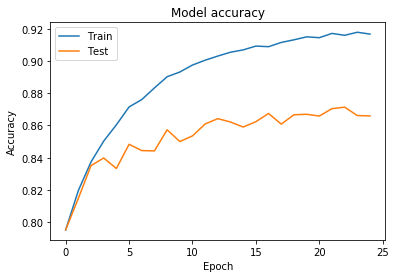

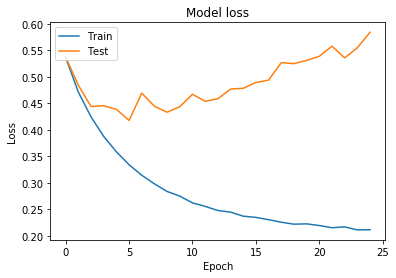

In [43]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Exploring model layers

In [295]:
NR_ENTRY = 

one_input = [[val_body[NR_ENTRY]], [val_claim[NR_ENTRY]], [val_p_tfidf[NR_ENTRY]]]

p_cnn_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('P_cnn').output)

p_cnn_pred = p_cnn_layer_model.predict(one_input)

most_sim_paragraph_index = p_cnn_pred.argmax()

most_sim_paragraph = [index2word[w] for w in one_input[0][0][most_sim_paragraph_index]]

# Full body

#[[index2word[w] for w in one_input[0][0][i]] for i in range(9)]

print("claim: ", [index2word[w] if w!=0 else 0 for w in one_input[1][0]])

cnn_maxout_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('CNN_maxout_docs').output)

cnn_maxout_pred = cnn_maxout_layer_model.predict(one_input)

cnn_maxout_pred.shape

ngramindex = cnn_maxout_pred[0][most_sim_paragraph_index].argmax()

print("most sim ngram: ", most_sim_paragraph[ngramindex:ngramindex+5])

print("stance: ", model.predict(one_input).argmax())

ValueError: Error when checking input: expected docs to have 3 dimensions, but got array with shape (1, 10, 9, 15)

```
    df.loc[df['Stance'] == 'unrelated', 'Stance'] = 0
    df.loc[df['Stance'] == 'discuss', 'Stance'] = 1
    df.loc[df['Stance'] == 'agree', 'Stance'] = 2
    df.loc[df['Stance'] == 'disagree', 'Stance'] = 3
    ```